# EEGMMIDB — Data Exploration & NeuroGPT Classification

Goal:
- Load the EEGMMIDB motor movement / imagery dataset
- Explore signals and labels
- Classification with NeuroGPT usage

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Project paths
PROJECT_ROOT = Path.cwd()
SRC_PATH = PROJECT_ROOT / "src"
DATA_PATH = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

sys.path.append(str(SRC_PATH))

from dataloader import EEGMMIDBDataset

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)

Project root: /home/jovyan/neuro-eeg
Data path: /home/jovyan/neuro-eeg/data/physionet.org/files/eegmmidb/1.0.0


In [2]:
import mne

edf = DATA_PATH / "S001" / "S001R03.edf"
raw = mne.io.read_raw_edf(edf, preload=False, verbose=False)

print(sorted(raw.ch_names))


['Af3.', 'Af4.', 'Af7.', 'Af8.', 'Afz.', 'C1..', 'C2..', 'C3..', 'C4..', 'C5..', 'C6..', 'Cp1.', 'Cp2.', 'Cp3.', 'Cp4.', 'Cp5.', 'Cp6.', 'Cpz.', 'Cz..', 'F1..', 'F2..', 'F3..', 'F4..', 'F5..', 'F6..', 'F7..', 'F8..', 'Fc1.', 'Fc2.', 'Fc3.', 'Fc4.', 'Fc5.', 'Fc6.', 'Fcz.', 'Fp1.', 'Fp2.', 'Fpz.', 'Ft7.', 'Ft8.', 'Fz..', 'Iz..', 'O1..', 'O2..', 'Oz..', 'P1..', 'P2..', 'P3..', 'P4..', 'P5..', 'P6..', 'P7..', 'P8..', 'Po3.', 'Po4.', 'Po7.', 'Po8.', 'Poz.', 'Pz..', 'T10.', 'T7..', 'T8..', 'T9..', 'Tp7.', 'Tp8.']


## Load Dataset for exploration

Subject 1, motor execution + imagery, left/right hand

Classes:
- 0: Right imagined
- 1: Right real
- 2: Left imagined
- 3: Left real

In [3]:
dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=[1],
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

print("Total extracted trials:", len(dataset))

Total extracted trials: 90


In [4]:
from collections import Counter

labels = [dataset[i]["labels"].item() for i in range(len(dataset))]

label_map = {
    0: "Right Imagined",
    1: "Right Real",
    2: "Left Imagined",
    3: "Left Real"
}

counts = Counter(labels)

print("Dataset-level class counts:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {counts.get(k, 0)}")


Dataset-level class counts:
Right Imagined : 22
Right Real     : 22
Left Imagined  : 23
Left Real      : 23


In [5]:
import mne
from collections import defaultdict

event_summary = defaultdict(lambda: defaultdict(int))

for run in [3, 4, 7, 8, 11, 12]:
    edf_path = DATA_PATH / "S001" / f"S001R{run:02d}.edf"
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    _, event_id = mne.events_from_annotations(raw, verbose=False)
    
    for label in event_id.keys():
        event_code = label.split("/")[-1]
        event_summary[run][event_code] += 1

print("Raw EDF annotation summary (Subject 1):\n")
for run, events in event_summary.items():
    print(f"Run {run}: {dict(events)}")


Raw EDF annotation summary (Subject 1):

Run 3: {'T0': 1, 'T1': 1, 'T2': 1}
Run 4: {'T0': 1, 'T1': 1, 'T2': 1}
Run 7: {'T0': 1, 'T1': 1, 'T2': 1}
Run 8: {'T0': 1, 'T1': 1, 'T2': 1}
Run 11: {'T0': 1, 'T1': 1, 'T2': 1}
Run 12: {'T0': 1, 'T1': 1, 'T2': 1}


In [6]:
print("Sample-wise label sanity check (first 10 trials):\n")

for i in range(10):
    sample = dataset[i]
    label = sample["labels"].item()
    print(f"Trial {i:02d} -> Class {label}: {label_map[label]}")


Sample-wise label sanity check (first 10 trials):

Trial 00 -> Class 1: Right Real
Trial 01 -> Class 3: Left Real
Trial 02 -> Class 3: Left Real
Trial 03 -> Class 1: Right Real
Trial 04 -> Class 1: Right Real
Trial 05 -> Class 3: Left Real
Trial 06 -> Class 3: Left Real
Trial 07 -> Class 1: Right Real
Trial 08 -> Class 3: Left Real
Trial 09 -> Class 1: Right Real


## Visual comparison: Right Imagined vs Right Real EEG signals

IndexError: index 7 is out of bounds for dimension 0 with size 1

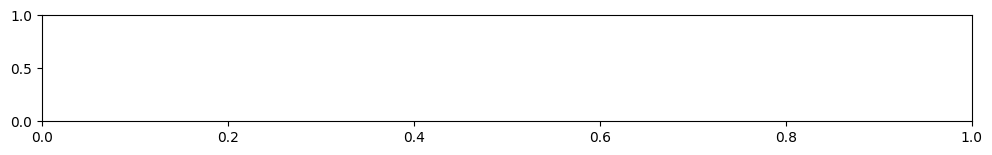

In [7]:
import matplotlib.pyplot as plt

"""
# sample channels
channel_names = [
    "C3", "C4", "Cz", "F3", "F4"
]


neurogpt_channels = [
    "Fp1","Fp2","F7","F3","Fz","F4","F8",
    "T1","T3","C3","Cz","C4","T4","T2",
    "T5","P3","Pz","P4","T6","O1","Oz","O2"
]
"""

# Focus on the Motor Strip (C-line) and surrounding areas
channel_names = [
    "C3",   # Primary Left Motor Cortex (Contralateral to Right Hand - MOST IMPORTANT)
    "Cz",   # Midline Motor Cortex
    "C4",   # Primary Right Motor Cortex (Ipsilateral)
    "FC3",  # Pre-motor area (Left)
    "CP3"   # Somatosensory/Post-central area (Left)
]

neurogpt_channels = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", 
    "C2", "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz"
]

channel_indices = [neurogpt_channels.index(ch) for ch in channel_names]

# Collect trials
imagined_trials = []
real_trials = []

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()

    # Right Imagined = 0, Right Real = 1
    if label == 0:
        imagined_trials.append(sample["inputs"])
    elif label == 1:
        real_trials.append(sample["inputs"])

# Compute average waveform per class
imagined_avg = torch.stack(imagined_trials).mean(dim=0)
real_avg = torch.stack(real_trials).mean(dim=0)

# Time axis (seconds)
sfreq = 250
time = np.arange(imagined_avg.shape[1]) / sfreq

# Plot
plt.figure(figsize=(12, 8))

for i, ch_idx in enumerate(channel_indices):
    plt.subplot(len(channel_indices), 1, i + 1)
    plt.plot(time, imagined_avg[ch_idx].numpy(), label="Right Imagined", alpha=0.8)
    plt.plot(time, real_avg[ch_idx].numpy(), label="Right Real", alpha=0.8)
    plt.ylabel(channel_names[i])
    if i == 0:
        plt.legend(loc="upper right")

plt.xlabel("Time (s)")
plt.suptitle("Subject 1 — Right Hand: Imagined vs Real EEG (Average Waveforms)", y=1.02)
plt.tight_layout()
plt.show()


In [8]:
import numpy as np

energy_by_class = defaultdict(list)

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()
    energy = sample["inputs"].pow(2).mean().item()
    energy_by_class[label].append(energy)

print("Mean signal energy per class:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {np.mean(energy_by_class[k]):.4f}")


Mean signal energy per class:
Right Imagined : 0.9163
Right Real     : 0.9236
Left Imagined  : 0.9129
Left Real      : 0.9253


## NeuroGPT Teaser

Each trial is already:
- 22-channel (NeuroGPT format)
- Normalized
- Fixed-length
- Labeled

In [9]:
batch = dataset[0]
print(batch["inputs"].shape)
print(batch["labels"].item())


torch.Size([1, 22, 500])
1


## Loading the train, test data

In [10]:
all_subjects = list(range(1, 109))  # subject range
print("Subjects:", all_subjects)

MI_ME_RUNS = [3, 4, 7, 8, 11, 12]
print("MI_ME runs:", MI_ME_RUNS)

Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
MI_ME runs: [3, 4, 7, 8, 11, 12]


In [11]:
# create folds

train_folds = []
test_folds = []

for i in range(len(all_subjects) // 2):
    test_subjects = all_subjects[i*2 : i*2+2]
    train_subjects = all_subjects[:i*2] + all_subjects[i*2+2:]

    train_folds.append(train_subjects)
    test_folds.append(test_subjects)


In [12]:
from src.dataloader import EEGMMIDBDataset

train_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=train_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

test_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=test_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

# Simple setup (same as your example)
validation_dataset = test_dataset

/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/ne

In [13]:
print("Train trials:", len(train_dataset))
print("Test trials :", len(test_dataset))

batch = train_dataset[0]
print("Input shape:", batch["inputs"].shape)   # (22, T)
print("Label:", batch["labels"].item())


Train trials: 9575
Test trials : 180
Input shape: torch.Size([1, 22, 500])
Label: 1


## Model

In [29]:
import os
import sys
import json
home = os.environ["HOME"]
python_imports = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder"
cache_root = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/"
sys.path.append(python_imports)

with open(os.path.join("NeuroGPT_mini/config.json"), "r", encoding="utf-8") as f:
    config = json.load(f)

In [30]:
import numpy as np
import torch
import os
import sys 
sys.path.insert(0,os.path.join('NeuroGPT_mini/') )
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score
import random
import json

### Import related to Transformer model (from files located in /NeuroGPT directory)

from encoder.conformer_braindecode import EEGConformer
from decoder.make_decoder import make_decoder
from embedder.make import make_embedder
from trainer.make import make_trainer
from trainer.base import Trainer
from decoder.unembedder import make_unembedder
import pandas as pd
from typing import Dict

import matplotlib.pyplot as plt

In [31]:
from dataloade.MIdataset import MotorImageryDataset

In [32]:
config_path = {"dst_data_path" : os.path.join(python_imports, "bciiv2a_eeg_npz/"),
         "pretrained_model" : os.path.join("NeuroGPT_mini/pytorch_model.bin"), 
         "log_dir" :os.path.join(python_imports,"training_logs/")}


In [33]:
# Compute the dataset (train, test, validation) 
downstream_path = config_path["dst_data_path"]
filenames = sorted(os.listdir(downstream_path))[:18]
print("Files from all the subjects : ", filenames)
train_folds = []
test_folds = []

for i in range(9):
    train_files = filenames[0:i*2] + filenames[i*2+2:]
    test_files = filenames[i*2 : i*2+2]


print("Train dataset : ")
print(train_files)


train_dataset = MotorImageryDataset(train_files, root_path=downstream_path)


print("Test dataset :")
print(test_files)

# On the way, compute the test dataset as :

## TO DO : instanciate a MotorImageryDataset object but with the testing files
# test_dataset = ... 
# YOUR CODE HERE
validation_dataset = MotorImageryDataset(test_files, root_path=downstream_path)


Files from all the subjects :  ['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz', 'A09E.npz', 'A09T.npz']
Train dataset : 
['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz']
Number of subjects loaded:  16
Test dataset :
['A09E.npz', 'A09T.npz']
Number of subjects loaded:  2


In [34]:
class Model(torch.nn.Module):
    """
    Create Model object from embedder, decoder,
    and unembedder (if not None).

    Args
    ----
    embedder: src.embedder.make_embedder
        Instance of embedder class.
    decoder: src.decoder.make_decoder
        Instance of decoder class.
    unembedder: src.unembedder.make_unembedder
        Instance of unembedder class.
        Only added to model if not None.

    Methods
    ----
    forward(batch: Dict[str, torch.tensor])
        Forward pass of model.
    prep_batch(batch: Dict[str, torch.tensor])
        Prepare batch for forward pass.
    compute_loss(batch: Dict[str, torch.tensor])
        Compute training loss.
    from_pretrained(pretrained_path: str)
        Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file 
    """
    def __init__(
        self,
        encoder: torch.nn.Module,
        embedder: torch.nn.Module,
        decoder: torch.nn.Module,
        unembedder: torch.nn.Module = None
        ) -> torch.nn.Module:
        
        super().__init__()
        self.name = f'Embedder-{embedder.name}_Decoder-{decoder.name}'
        self.encoder = encoder
        self.embedder = embedder
        self.decoder = decoder
        self.unembedder = unembedder
        self.is_decoding_mode = False
        self.ft_only_encoder = False

    def from_pretrained(
        self,
        pretrained_path: str
        ) -> None:
        """Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file.
        """
        print(
            f'Loading pretrained model from {pretrained_path}'
        )

        if next(self.parameters()).is_cuda:
            pretrained = torch.load(pretrained_path)

        else:
            pretrained = torch.load(pretrained_path, map_location=torch.device('cpu'))
        
        for k in self.state_dict():
            
            if k in pretrained:
                assert pretrained[k].shape == self.state_dict()[k].shape,\
                    f'{k} shape mismatch between pretrained model and current model '+\
                    f'{pretrained[k].shape} vs {self.state_dict()[k].shape}'
        
        for k in pretrained:     
            if k not in self.state_dict():
                warnings.warn(
                    f'Warning: /!\ Skipping {k} from {pretrained_path} '\
                    'because it is not part of the current model'
                )

        # we set strict=False, because we can be sure
        # that all relevant keys are in pretrained
        self.load_state_dict(pretrained, strict=False)
        
    def switch_ft_mode(self, ft_encoder_only=False):
        self.ft_only_encoder = ft_encoder_only

    def switch_decoding_mode(
        self,
        is_decoding_mode: bool = False,
        num_decoding_classes: int = None
        ) -> None:
        """Switch model to decoding model or back to training mode.
        Necessary to adapt pre-trained models to downstream
        decoding tasks.
        
        Args
        ----
        is_decoding_mode: bool
            Whether to switch to decoding mode or not.
        num_decoding_classes: int
            Number of classes to use for decoding.    
        """
        self.is_decoding_mode = is_decoding_mode
        
        self.embedder.switch_decoding_mode(is_decoding_mode=is_decoding_mode)
        self.decoder.switch_decoding_mode(
            is_decoding_mode=is_decoding_mode,
            num_decoding_classes=num_decoding_classes
        )

    def compute_loss(
        self,
        batch: Dict[str, torch.tensor],
        return_outputs: bool = False
        ) -> Dict[str, torch.tensor]:
        """
        Compute training loss, based on 
        embedder's training-style.

        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        return_outputs: bool
            Whether to return outputs of forward pass
            or not. If False, only loss is returned.

        Returns
        ----
        losses: Dict[str, torch.tensor]
            Training losses.
        outputs: torch.tensor
            Outputs of forward pass.
        """
        (outputs, batch) = self.forward(
            batch=batch,
            return_batch=True
        )
        losses = self.embedder.loss(
            batch=batch,
            outputs=outputs
        )

        return (losses, outputs) if return_outputs else losses

    def prep_batch(
        self,
        batch: Dict[str, torch.tensor]
        ) -> Dict[str, torch.tensor]:
        """Prepare input batch for forward pass.
        Calls src.embedder.prep_batch.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        """
        return self.embedder.prep_batch(batch=dict(batch))

    def forward(
        self,
        batch: Dict[str, torch.tensor],
        prep_batch: bool = True,
        return_batch: bool = False
        ) -> torch.tensor:
        """
        Forward pass of model.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        prep_batch: bool
            Whether to prep batch for forward pass
            by calling self.embedder.prep_batch
        return_batch: bool
            Whether to return batch after forward pass
            or not. If False, only outputs of forward pass
            are returned.

        Returns
        ----
        outputs: torch.tensor
            Outputs of forward pass.
        batch: Dict[str, torch.tensor]
            Input batch (as returned by prep_batch, 
            if prep_batch is True)
        """
        
        if self.encoder is not None:
            #before prep_batch masking and things, we need to first let the splitted chunks of raw input through the encoder
            features = self.encoder(batch['inputs'])
            #attempt for trying fine-tune only the encoder, but the encoder cannot combine information across chunks.
            if self.is_decoding_mode and self.ft_only_encoder:
                outputs={'outputs': features, 'decoding_logits': features}
                return (outputs, batch) if return_batch else outputs

            b, f1, f2 = features.size()
            nchunks = batch['inputs'].size()[1]
            batch['inputs'] = features.view(b//nchunks, nchunks, f1*f2)
        
        if prep_batch:
            if len(batch['inputs'].size()) > 3:
                bsize, chunk, chann, time = batch['inputs'].size() 
                batch['inputs'] = batch['inputs'].view(bsize, chunk, chann*time)
            batch = self.prep_batch(batch=batch)
            # batch['inputs_embeds'] = batch['inputs_embeds'].view(bsize, chunk, chann, time)
            # print("preparing batch")
        else:
            assert 'inputs_embeds' in batch, 'inputs_embeds not in batch'

        # pdb.set_trace()
        batch['inputs_embeds'] = self.embedder(batch=batch)
        outputs = self.decoder(batch=batch)
        
        if self.unembedder is not None and not self.is_decoding_mode:
            outputs['outputs'] = self.unembedder(inputs=outputs['outputs'])['outputs']

        return (outputs, batch) if return_batch else outputs

In [35]:
def make_model(model_config) : 
# Generate the model
    
    
    ## Encoder
    
    if model_config["use_encoder"] == True:
        
        chann_coords = None
        encoder = EEGConformer(n_outputs=model_config["num_decoding_classes"], n_chans=22, n_times=model_config['chunk_len'], ch_pos=chann_coords, is_decoding_mode=model_config["ft_only_encoder"])
        #calculates the output dimension of the encoder, which is the output of transformer layer.
        model_config["parcellation_dim"] = ((model_config['chunk_len'] - model_config['filter_time_length'] + 1 - model_config['pool_time_length']) // model_config['stride_avg_pool'] + 1) * model_config['n_filters_time']

    else:
        encoder = None
        model_config["parcellation_dim"] = model_config["chunk_len"] * 22
    
    ## Embedder
    
    embedder = make_embedder(
        training_style=model_config["training_style"],
        architecture=model_config["architecture"],
        in_dim=model_config["parcellation_dim"], # flattened, channel x chunk length
        embed_dim=model_config["embedding_dim"],
        num_hidden_layers=model_config["num_hidden_layers_embedding_model"],
        dropout=model_config["dropout"],
        n_positions=model_config["n_positions"]
    )
    
    ## Decoder
    decoder = make_decoder(
        architecture=model_config["architecture"],
        num_hidden_layers=model_config["num_hidden_layers"],
        embed_dim=model_config["embedding_dim"],
        num_attention_heads=model_config["num_attention_heads"],
        n_positions=model_config["n_positions"],
        intermediate_dim_factor=model_config["intermediate_dim_factor"],
        hidden_activation=model_config["hidden_activation"],
        dropout=model_config["dropout"]
    )
   
    
    if model_config["embedding_dim"] != model_config["parcellation_dim"]:
        unembedder = make_unembedder(
            embed_dim=model_config["embedding_dim"],
            num_hidden_layers=model_config["num_hidden_layers_unembedding_model"],
            out_dim=model_config["parcellation_dim"],
            dropout=model_config["dropout"],
        )
    else:
        print("No Embedder and Unembedder!")
        unembedder = None
    
    
    
    model = Model(
        encoder=encoder,
        embedder=embedder,
        decoder=decoder,
        unembedder=unembedder
    )
    
    if model_config["ft_only_encoder"]:
        model.switch_ft_mode(ft_encoder_only=True)
    
    if model_config["training_style"] == 'decoding':
        model.switch_decoding_mode(
            is_decoding_mode=True,
            num_decoding_classes=model_config["num_decoding_classes"]
        )
    
    if model_config["pretrained_model"] is not None:
        model.from_pretrained(model_config["pretrained_model"])
    
    if model_config["freeze_embedder"]:
        for param in model.embedder.parameters():
            param.requires_grad = False
    
    if model_config["freeze_decoder"]:

        ## TO DO : freeze the parameters of the decoder module :
        for param in model.decoder.parameters():
            param.requires_grad = False
            
    if model_config["freeze_encoder"]:
        for name, param in model.encoder.named_parameters():
            if 'fc.' in name \
            or 'final_layer' in name:
                continue
            else:
                param.requires_grad = False
        print('Frozen Encoder : Only the two last layers will be trained')
    
    if 'freeze_decoder_without_pooler_heads' in model_config \
        and model_config["freeze_decoder_without_pooler_heads"]:
        for name, param in model.decoder.named_parameters():
            if 'pooler_layer' in name \
            or 'decoding_head' in name \
            or 'is_next_head' in name:
    

                continue
            else:
                param.requires_grad = False
    
    if model_config["freeze_unembedder"] and unembedder is not None:
        for param in model.unembedder.parameters():
            param.requires_grad = False
    return model

In [36]:
model_config = config

## Some important parameters in the architecture of the model 

model_config['pretrained_model'] = config_path['pretrained_model'] # Path to the file containing pretrained weights of the model, if model_config['pretrained_model'] = None the model is not pretrained
model_config['embedding_dim'] = 1024 # Dimension of the latent representations in the model
model_config['num_hidden_layers_embedding_model']= 1 # Number of hidden layers in the GPT model 
model_config['num_hidden_layers_unembedding_model']= 1 # Number of hidden layers on the unembedding module 
model_config['num_hidden_layers']= 6  #Number of hidden layers in the encoder module
model_config['filter_time_length']= 25 #Size of the kernel of the temporal convolution layer 
model_config['stride_avg_pool']= 15  # Stride size used in the average-pooling operation
model_config["freeze_encoder"] = False # Whether to freeze the encoder (True = no training on encoder parameters, only the classification layer)


model = make_model(model_config)

FC Layer for Classification created.
Loading pretrained model from NeuroGPT_mini/pytorch_model.bin


In [37]:
trainer_config = config

# Some important paramerter to build up the training stategy

trainer_config['model_init'] = make_model # Function used to instanciate a model
trainer_config['run_name'] = 'Finetunning_1' # Name of the run to save logs in a directory 
trainer_config['train_dataset'] = train_dataset 
trainer_config['validation_dataset'] = validation_dataset
trainer_config['output_dir'] = os.path.join(config_path['log_dir'], trainer_config['run_name']) # Where to save training logs

trainer_config['training_steps'] = 3000 # Number of training steps
trainer_config['validation_steps'] = 500 # Number of validation steps
# Whether to freeze the encoder (True = no training on encoder parameters)
trainer_config['model_save_steps'] = config["training_steps"]*2
trainer_config['log_every_n_steps'] = 1000
trainer_config['eval_every_n_steps'] = 500
trainer_config['warmup_ratio'] = 0.01
trainer_config['optim'] = "adamw_torch"


In [38]:
trainer = make_trainer(model_init=lambda: make_model(model_config), config = trainer_config) 

FC Layer for Classification created.
Loading pretrained model from NeuroGPT_mini/pytorch_model.bin


In [39]:
trainer.train()
print("End of the training ! ")
save_path = os.path.join(config["log_dir"], trainer_config['run_name'], 'model_final')

FC Layer for Classification created.
Loading pretrained model from NeuroGPT_mini/pytorch_model.bin


Step,Training Loss
1,1.443000
1000,1.088600
2000,0.843700
3000,0.746600


End of the training ! 


In [40]:
trainer.save_model(save_path)

The model has been saved to :  training_logs/Finetunning_1/model_final


## Evaluation

In [41]:
def get_performance_from_trainer(trainer, test_dataset):
    """
    This function takes as input a trainer that has already been trained 
    (So the the trainer.train() method must already been called on it)
    And it returns the a dictionnary with the different performance metrics. 
    """
    test_prediction_ = trainer.predict(test_dataset)
    test_preds = test_prediction_.predictions
    test_labels = test_prediction_.label_ids
    pred_label=np.argmax(test_preds, axis=1)

    true_label = test_labels
    pred_label = pred_label 
    balanced_acc = balanced_accuracy_score(true_label, pred_label)

    kappa = cohen_kappa_score(true_label, pred_label)

    weighted_f1 = f1_score(true_label, pred_label, average='weighted')

    cm = confusion_matrix(true_label, pred_label)
    
    return {
        'Balanced Accuracy': balanced_acc,
        'Cohen s Kappa': kappa, 
        'Weighted F1-score': weighted_f1,
        'Confusion Matrix': cm 
    }


In [42]:
from src.dataloader import EEGMMIDBDataset
sample_batch = next(iter(trainer.get_test_dataloader(test_dataset)))
print(f"Inputs shape: {sample_batch['inputs'].shape}")


Inputs shape: torch.Size([16, 1, 22, 500])


In [43]:
print(get_performance_from_trainer(trainer, test_dataset))

ValueError: Expected input batch_size (8) to match target batch_size (16).